# Example: Effect of wavefront aberrations in atom interferometry

As an example, we reproduce two plots from the paper https://link.springer.com/article/10.1007/s00340-015-6138-5.

The simulation will require the following objects and parameters
* `Wavefront`: contains the wavefront aberrations of the interferometry lasers
* `AtomicEnsemble`: an ensemble of atoms which different trajectories or phase space vectors
* `Detector`: determines which atoms contribute to the signal
* times of the three interferometer pulses
* effective wavevector

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

### Loading and preparing wavefront data

Wavefront aberration in multiples of $\lambda$ = 780 nm. 

Load Zernike coefficients from file:

In [2]:
coeff_window = np.loadtxt('data/wf_window.txt')

Creating `Wavefront` objects and removing piston, tip and tilt from the data:

In [3]:
r_beam = 11e-3 # radius of the available wavefront data in m

wf = ais.Wavefront(r_beam, coeff_window)
for n in [0,1,2]:
    wf.coeff[n] = 0

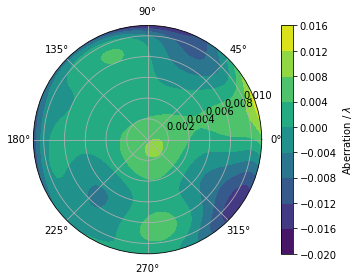

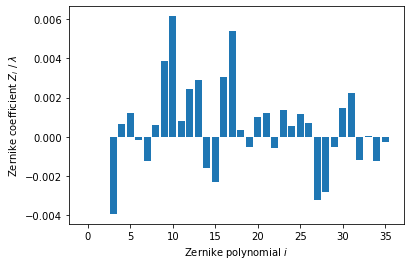

In [4]:
wf.plot()
fig, ax = wf.plot_coeff()

### Creating an atomic ensemble

Due to the large number of parameters determining an atomic ensemble, dictionaries are used:

In [5]:
pos_params = {
    'std_rho' : 3.0e-3, # cloud radius in m
    'std_z' : 0,        # ignore z dimension, its not relevant here
    'n_rho' : 20,       # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,     # using a resolution of 10°
    'n_z' : 1,          # use one value for the distribution along z
    'm_std_rho' : 3,    # use 3 standard deviations of the distribution, i.e. atoms up to 9 mm away from the center
    'm_std_z' : 0,      # ignore z dimension, its not relevant here 
}

vel_params = {
    'std_rho' : ais.vel_from_temp(3e-6), # velocity spread in m/s from a temperature of 3 uK
    'std_z' : 0,                         # ignore z dimension, its not relevant here
    'n_rho' : 20,                        # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,                      # using a resolution of 10°
    'n_z' : 1,                           # use one value for the distribution along z
    'm_std_rho' : 3,                     # use 3 standard deviations of the distribution
    'm_std_z' : 0,                       # ignore z dimension, its not relevant here 
}

atoms = ais.create_ensemble_from_grids(pos_params, vel_params)

Plotting the grid and the weights:

In [6]:
x = atoms.initial_position[:, 0]
y = atoms.initial_position[:, 1]

Text(0, 0.5, 'y / mm')

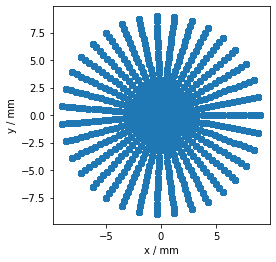

In [7]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, 1e3*y)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x / mm')
ax.set_ylabel('y / mm')

Text(0, 0.5, 'weights')

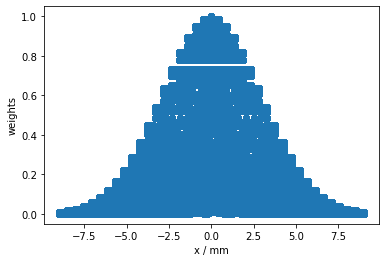

In [8]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, atoms.weights)
ax.set_xlabel('x / mm')
ax.set_ylabel('weights')

### Setting up the detector

We want to calculate the dependency of the phase shift caused by wavefront aberrations on the detection area. For this reason, we set up a Detector with varying detection radius within a for-loop.

In [9]:
t_det = 778e-3 # time of the detection in s

### Simulation the bias in gravity from wavefront aberrations

For the simulation we need the objects created above and the timing of the interferometer sequence.

In [10]:
T = 260e-3 # interferometer time in s
t1 = 130e-3 # time of first pulse in s
t2 = t1 + T
t3 = t2 + T

In [11]:
awfs = []
r_dets = np.linspace(2e-3, 10e-3, 10)
for r_det in r_dets:
    # creating detector with new detection radius
    det = ais.PolarDetector(t_det, r_det=r_det)
    
    det_atoms = det.detected_atoms(atoms)
    
    # calculate the imprinted phase for each "test atom" at each pulse. This is the computationally heavy part
    phi1 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t1))
    phi2 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t2))
    phi3 = 2 * np.pi * wf.get_value(det_atoms.calc_position(t3))

    # calculate a complex amplitude factor for the Mach-Zehnder sequence and
    # weight their contribution to the signal
    awf = np.exp(1j * (phi1 - 2*phi2 + phi3))
    weighted_awf = np.sum(det_atoms.weights * awf) / np.sum(det_atoms.weights)    

    awfs.append(weighted_awf)
    
g = ais.phase_to_grav(np.angle(awfs), T=260e-3, keff=1.610574779769e6)

We load the measured gravity data from a file and compare it to the simulation results.

In [12]:
data = np.loadtxt('data/wf_grav_data.csv', skiprows=1, delimiter=',')
r_det_data = data[:, 0]
grav = data[:, 1]
graverr = data[:, 2]

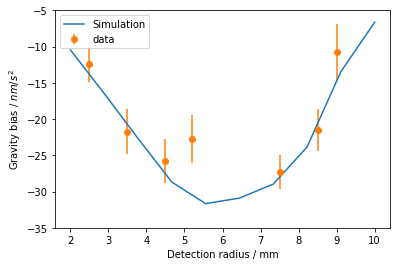

In [13]:
fig, ax = plt.subplots()
ax.plot(1e3*r_dets, 1e9*g, label='Simulation')
ax.errorbar(1e3*r_det_data, 1e9*grav, yerr=1e9*graverr, fmt='o', label='data')
ax.set_xlabel('Detection radius / mm')
ax.set_ylabel('Gravity bias / $nm/s^2$');
ax.set_ylim([-35, -5])
ax.legend()

Note that a different simulation software with different simulation parameters was used in the aformentioned paper, so some differences are to be expected.